In [61]:
import pandas as pd
import numpy as np

from catboost import CatBoostRegressor
import lightgbm as lgb
import optuna
import xgboost as xgb
from sklearn.model_selection import cross_val_score, KFold
from sklearn.metrics import mean_squared_error

import pickle

In [62]:
college_data = pd.read_csv("/Users/aidanbeilke/Desktop/Purdue_Base/newman_proj/csvs/college_2024_pitch_type.csv")
college_heights = pd.read_csv("/Users/aidanbeilke/Desktop/Purdue_Base/newman_proj/csvs/college_height.csv")

/var/folders/z9/0qsxxzxs1hb9r22xy18sfdbc0000gn/T/ipykernel_62964/4106798530.py:1: DtypeWarning: Columns (27,92,93,94) have mixed types. Specify dtype option on import or set low_memory=False.
  college_data = pd.read_csv("/Users/aidanbeilke/Desktop/Purdue_Base/newman_proj/csvs/college_2024_pitch_type.csv")


In [63]:
college_data.shape

(1462896, 169)

In [64]:
[c for c in college_data.columns]

['PitchNo',
 'Date',
 'Time',
 'PAofInning',
 'PitchofPA',
 'Pitcher',
 'PitcherId',
 'PitcherThrows',
 'PitcherTeam',
 'Batter',
 'BatterId',
 'BatterSide',
 'BatterTeam',
 'PitcherSet',
 'Inning',
 'Top.Bottom',
 'Outs',
 'Balls',
 'Strikes',
 'TaggedPitchType',
 'AutoPitchType',
 'PitchCall',
 'KorBB',
 'TaggedHitType',
 'PlayResult',
 'OutsOnPlay',
 'RunsScored',
 'Notes',
 'RelSpeed',
 'VertRelAngle',
 'HorzRelAngle',
 'SpinRate',
 'SpinAxis',
 'Tilt',
 'RelHeight',
 'RelSide',
 'Extension',
 'VertBreak',
 'InducedVertBreak',
 'HorzBreak',
 'PlateLocHeight',
 'PlateLocSide',
 'ZoneSpeed',
 'VertApprAngle',
 'HorzApprAngle',
 'ZoneTime',
 'ExitSpeed',
 'Angle',
 'Direction',
 'HitSpinRate',
 'PositionAt110X',
 'PositionAt110Y',
 'PositionAt110Z',
 'Distance',
 'LastTrackedDistance',
 'Bearing',
 'HangTime',
 'pfxx',
 'pfxz',
 'x0',
 'y0',
 'z0',
 'vx0',
 'vy0',
 'vz0',
 'ax0',
 'ay0',
 'az0',
 'HomeTeam',
 'AwayTeam',
 'Stadium',
 'Level',
 'League',
 'GameID',
 'PitchUID',
 'Effec

In [65]:
if 'PUR_BOI' in college_data['PitcherTeam'].values:
    print("'PUR_BOI' is an option for PitcherTeam.")
else:
    print("'PUR_BOI' is not an option for PitcherTeam.")


'PUR_BOI' is an option for PitcherTeam.


In [66]:
# Omit Purdue Pitchers to avoid Overfitting
college_data = college_data[college_data['PitcherTeam'] != "PUR_BOI"]

college_data.shape

(1455983, 169)

## Arm Angle

#### Rename Columns to Match and Apply Model

In [67]:
college_data = college_data.rename(columns={
    'RelSide' : 'release_pos_x',
    'RelHeight' : 'release_pos_z',
    'Extension' : 'release_extension',
    'Pitcher' : 'player_name'
})

In [68]:
college_heights

,player_name,height_in_inches
0,Griffen Leiner,75
1,Walker Retz,75
2,Carl Cano,73
3,Tucker Huhn,74
4,Cooper Smith,70
...,...,...
5421,Jacob Crystal,74
5422,Kennen Smith,76
5423,Steven Freer,75
5424,Billy Hoffacker,78


In [69]:
college_data[['player_name', 'release_pos_x', 'release_pos_z', 'release_extension']]

,player_name,release_pos_x,release_pos_z,release_extension
0,"Riesselmann, Kyle",-1.44574,6.31403,6.76348
1,"Riesselmann, Kyle",-1.30030,6.35450,6.81629
2,"Riesselmann, Kyle",-1.71443,6.28361,5.60393
3,"Riesselmann, Kyle",-1.72609,6.25576,6.12353
4,"Riesselmann, Kyle",-1.33869,6.28872,6.93845
...,...,...,...,...
1462891,"Campbell, Carter",-2.34523,5.62859,5.16784
1462892,"Campbell, Carter",-2.40351,5.56104,5.34491
1462893,"Campbell, Carter",-2.21696,5.74825,5.23837
1462894,"Campbell, Carter",-2.24819,5.75552,5.09948


In [70]:
college_data = college_data[college_data['player_name'] != "O'Brien Cameron"]

def format_name(name):
    try:
        last, first = name.split(", ")
        return f"{first} {last}"
    except ValueError:
        # Return the name as is if it doesn't match the expected format
        return name

college_data['player_name'] = college_data['player_name'].apply(format_name)

In [71]:
college_data = college_data.merge(college_heights, 
                                  on = 'player_name', 
                                  how = 'left')

In [72]:
college_data['interaction'] =  college_data['release_pos_z'] * college_data['release_extension'] * college_data['height_in_inches']
feats = ['release_pos_x', 'release_pos_z', 'release_extension', 'height_in_inches', 'interaction']

college_data = college_data.dropna(subset = feats)

college_data.shape

(1098219, 171)

In [73]:
college_data[['player_name', 'release_pos_x', 'release_pos_z', 'release_extension', 'height_in_inches', 'interaction']]

,player_name,release_pos_x,release_pos_z,release_extension,height_in_inches,interaction
11,Michael Lorenzetti,1.95841,5.16556,7.03804,81.0,2944.788850
12,Michael Lorenzetti,2.01048,5.26479,6.76113,81.0,2883.270299
13,Michael Lorenzetti,1.96620,5.14087,6.82406,81.0,2841.610032
14,Michael Lorenzetti,1.97864,5.14348,6.92233,81.0,2883.994139
15,Michael Lorenzetti,2.04028,5.20980,6.90635,81.0,2914.436881
...,...,...,...,...,...,...
1471640,Carter Campbell,-2.34523,5.62859,5.16784,74.0,2152.486288
1471641,Carter Campbell,-2.40351,5.56104,5.34491,74.0,2199.521115
1471642,Carter Campbell,-2.21696,5.74825,5.23837,74.0,2228.248066
1471643,Carter Campbell,-2.24819,5.75552,5.09948,74.0,2171.911776


### Load and Apply Arm Angle Model

In [74]:
catboost = "/Users/aidanbeilke/Desktop/Purdue_Base/newman_proj/models/best_catboost_model.pkl"

with open(catboost, 'rb') as cb_file:
    catboost_model = pickle.load(cb_file)

In [75]:
pred_arm_angle = catboost_model.predict(college_data[feats])

In [76]:
college_data['arm_angle'] = pred_arm_angle

In [77]:
college_data[['player_name', 'release_pos_x', 'release_pos_z', 'release_extension', 'height_in_inches', 'interaction', 'arm_angle']]

,player_name,release_pos_x,release_pos_z,release_extension,height_in_inches,interaction,arm_angle
11,Michael Lorenzetti,1.95841,5.16556,7.03804,81.0,2944.788850,20.798082
12,Michael Lorenzetti,2.01048,5.26479,6.76113,81.0,2883.270299,21.614743
13,Michael Lorenzetti,1.96620,5.14087,6.82406,81.0,2841.610032,19.947400
14,Michael Lorenzetti,1.97864,5.14348,6.92233,81.0,2883.994139,20.396942
15,Michael Lorenzetti,2.04028,5.20980,6.90635,81.0,2914.436881,20.566563
...,...,...,...,...,...,...,...
1471640,Carter Campbell,-2.34523,5.62859,5.16784,74.0,2152.486288,27.964893
1471641,Carter Campbell,-2.40351,5.56104,5.34491,74.0,2199.521115,29.054616
1471642,Carter Campbell,-2.21696,5.74825,5.23837,74.0,2228.248066,32.099621
1471643,Carter Campbell,-2.24819,5.75552,5.09948,74.0,2171.911776,29.138728


## Run Values

In [78]:
print(college_data['PitchCall'].unique())
print(college_data['PlayResult'].unique())

['BallCalled' 'StrikeCalled' 'InPlay' 'StrikeSwinging' 'FoulBall'
 'BallinDirt' 'HitByPitch' 'BallIntentional' 'FoulBallFieldable'
 'FoulBallNotFieldable' 'FouldBallNotFieldable' 'Undefined'
 'StrkeSwinging' 'BattersInterference' 'StriekC']
['Undefined' 'Out' 'Single' 'Double' 'Sacrifice' 'HomeRun' 'Error'
 'FieldersChoice' 'Triple' 'StolenBase' 'CaughtStealing' 'SIngle'
 'homerun' 'error']


In [79]:
df_run_values = pd.read_csv("/Users/aidanbeilke/Downloads/run_values.csv")

des_dict = {
    'InPlay' : 'InPlay',
    'BallCalled': 'ball',
    'BallinDirt' : 'ball',
    'BallIntentional' : 'ball',
    'HitByPitch' : 'hit_by_pitch',
    'StrikeCalled' : 'called_strike',
    'StrikeSwinging' : 'swinging_strike',
    'StrkeSwinging' : 'swinging_strike',
    'FoulBall' : 'foul',
    'FoulBallFieldable' : 'foul',
    'FoulBallNotFieldable' : 'foul',
    'FouldBallNotFieldable' : 'foul',
    'BattersInterference' : None,
    'StriekC' : None
}

event_dic = {
    'Undefined' : None,
    'Out' : 'field_out',
    'Single' : 'single',
    'SIngle' : 'single',
    'Double' : 'double',
    'Triple' : 'triple',
    'HomeRun' : 'home_run',
    'homerun' : 'home_run',
    'Sacrifice' : 'field_out',
    'Error' : 'field_out',
    'error' : 'field_out',
    'FieldersChoice' : 'field_out',
    'StolenBase' : None,
    'CaughtStealing': None,
}

korbb_dict = {
    'Undefined' : None,
    'Strikeout' : 'strikeout',
    'Walk' : 'walk'
}

college_data['PitchCall'] = college_data['PitchCall'].map(des_dict)
college_data['PlayResult'] = college_data['PlayResult'].map(event_dic)
college_data['KorBB'] = college_data['KorBB'].map(korbb_dict)


In [80]:
def create_pitch_event(row):
    if row['KorBB'] is not None:
        return row['KorBB']
    elif row['PitchCall'] == 'InPlay':
        return row['PlayResult']
    else:
        return row['PitchCall']

college_data['pitch_event'] = college_data.apply(create_pitch_event, axis = 1)

college_data = college_data.dropna(subset = 'pitch_event')

In [81]:
print(sorted(college_data['pitch_event'].unique()))
print(sorted(df_run_values['event'].unique()))

['ball', 'called_strike', 'double', 'field_out', 'foul', 'hit_by_pitch', 'home_run', 'single', 'strikeout', 'swinging_strike', 'triple', 'walk']
['ball', 'called_strike', 'double', 'field_out', 'foul', 'hit_by_pitch', 'home_run', 'single', 'strikeout', 'swinging_strike', 'triple', 'walk']


In [82]:
college_data = college_data.merge(df_run_values,
                                  left_on= ['pitch_event', 'Balls', 'Strikes'],
                                  right_on= ['event', 'balls', 'strikes'],
                                  how = 'left')

In [83]:
college_data[['pitch_event', 'Balls', 'Strikes', 'delta_run_exp']]

,pitch_event,Balls,Strikes,delta_run_exp
0,ball,0,0,0.034661
1,ball,1,0,0.059995
2,called_strike,2,0,-0.060725
3,ball,2,1,0.099768
4,field_out,3,1,-0.387370
...,...,...,...,...
1098189,called_strike,0,0,-0.038869
1098190,ball,0,1,0.025701
1098191,field_out,1,1,-0.240501
1098192,foul,0,0,-0.042103


## Expected iVB Model

In [84]:
cape = pd.read_csv("/Users/aidanbeilke/Desktop/Purdue_Base/newman_proj/csvs/cape_2024_pitch_type.csv")

cape.shape

/var/folders/z9/0qsxxzxs1hb9r22xy18sfdbc0000gn/T/ipykernel_62964/825213301.py:1: DtypeWarning: Columns (27) have mixed types. Specify dtype option on import or set low_memory=False.
  cape = pd.read_csv("/Users/aidanbeilke/Desktop/Purdue_Base/newman_proj/csvs/cape_2024_pitch_type.csv")


(58079, 169)

In [85]:
cape = cape.rename(columns={
    'RelSide' : 'release_pos_x',
    'RelHeight' : 'release_pos_z',
    'Extension' : 'release_extension',
    'Pitcher' : 'player_name'
})
def format_name(name):
    try:
        last, first = name.split(", ")
        return f"{first} {last}"
    except ValueError:
        # Return the name as is if it doesn't match the expected format
        return name

cape['player_name'] = cape['player_name'].apply(format_name)

cape = cape.merge(college_heights, 
                                  on = 'player_name', 
                                  how = 'left')

cape['interaction'] =  cape['release_pos_z'] * cape['release_extension'] * cape['height_in_inches']
cape = cape.dropna(subset = feats)
cape_arm_angle = catboost_model.predict(cape[feats])

cape['arm_angle'] = cape_arm_angle

In [86]:
features = ['arm_angle', 'release_pos_x', 'release_pos_z', 'release_extension', 'RelSpeed', 'SpinRate']
target = 'InducedVertBreak'

In [87]:
cape = cape.dropna(subset= features + [target])

X = cape[features]
y = cape[target]

def objective(trial):
    param = {
        "verbosity": 0,
        "objective": "reg:squarederror",
        "booster": "gbtree",
        "lambda": trial.suggest_float("lambda", 1e-8, 1.0, log=True),
        "alpha": trial.suggest_float("alpha", 1e-8, 1.0, log=True),
        "n_estimators": trial.suggest_int("n_estimators", 100, 1000),
        "max_depth": trial.suggest_int("max_depth", 3, 9),
        "eta": trial.suggest_float("eta", 0.01, 0.3, log=True),
        "gamma": trial.suggest_float("gamma", 1e-8, 1.0, log=True),
        "grow_policy": trial.suggest_categorical("grow_policy", ["depthwise", "lossguide"]),
        "subsample": trial.suggest_float("subsample", 0.5, 1.0),
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.5, 1.0),
        "min_child_weight": trial.suggest_int("min_child_weight", 1, 10),
    }
    
    #define XGBRegressor and use rmse as eval metric
    model = xgb.XGBRegressor(**param, eval_metric='rmse', use_label_encoder=False)

    #set up KFold CV
    kf = KFold(n_splits=5, shuffle=True, random_state=13)
    rmse_scores = cross_val_score(model, X, y, scoring='neg_root_mean_squared_error', cv=kf, n_jobs=-1)
    
    return -np.mean(rmse_scores)

#initialize Optuna study
study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=50)

print("Best hyperparameters:", study.best_params)
best_params = study.best_params

#train final model with best params
ivb_model = xgb.XGBRegressor(**best_params)
ivb_model.fit(X, y)

[I 2025-01-08 20:45:12,453] A new study created in memory with name: no-name-567342fd-44f3-42b6-b076-b4c12a0f9c91
[I 2025-01-08 20:45:23,100] Trial 0 finished with value: 4.648271959278938 and parameters: {'lambda': 6.798757690487539e-05, 'alpha': 0.00030136518455440875, 'n_estimators': 949, 'max_depth': 3, 'eta': 0.04406824666421472, 'gamma': 9.467903112334487e-07, 'grow_policy': 'lossguide', 'subsample': 0.8142791994438422, 'colsample_bytree': 0.7908757254494673, 'min_child_weight': 3}. Best is trial 0 with value: 4.648271959278938.
[I 2025-01-08 20:45:26,309] Trial 1 finished with value: 4.480281465758559 and parameters: {'lambda': 2.5178287622449277e-05, 'alpha': 0.0006182579710580827, 'n_estimators': 395, 'max_depth': 6, 'eta': 0.02435970468784223, 'gamma': 6.434217502115211e-05, 'grow_policy': 'depthwise', 'subsample': 0.7733837690733513, 'colsample_bytree': 0.6391962268702382, 'min_child_weight': 1}. Best is trial 1 with value: 4.480281465758559.
[I 2025-01-08 20:45:29,362] Tria

Best hyperparameters: {'lambda': 0.37246441965271454, 'alpha': 6.006207111084751e-06, 'n_estimators': 971, 'max_depth': 9, 'eta': 0.03440540094981703, 'gamma': 0.0002034616908696124, 'grow_policy': 'depthwise', 'subsample': 0.853857856342829, 'colsample_bytree': 0.8564366426919551, 'min_child_weight': 3}


XGBRegressor(alpha=6.006207111084751e-06, base_score=None, booster=None,
             callbacks=None, colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.8564366426919551, device=None,
             early_stopping_rounds=None, enable_categorical=False,
             eta=0.03440540094981703, eval_metric=None, feature_types=None,
             gamma=0.0002034616908696124, grow_policy='depthwise',
             importance_type=None, interaction_constraints=None,
             lambda=0.37246441965271454, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=9, max_leaves=None,
             min_child_weight=3, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=971, ...)

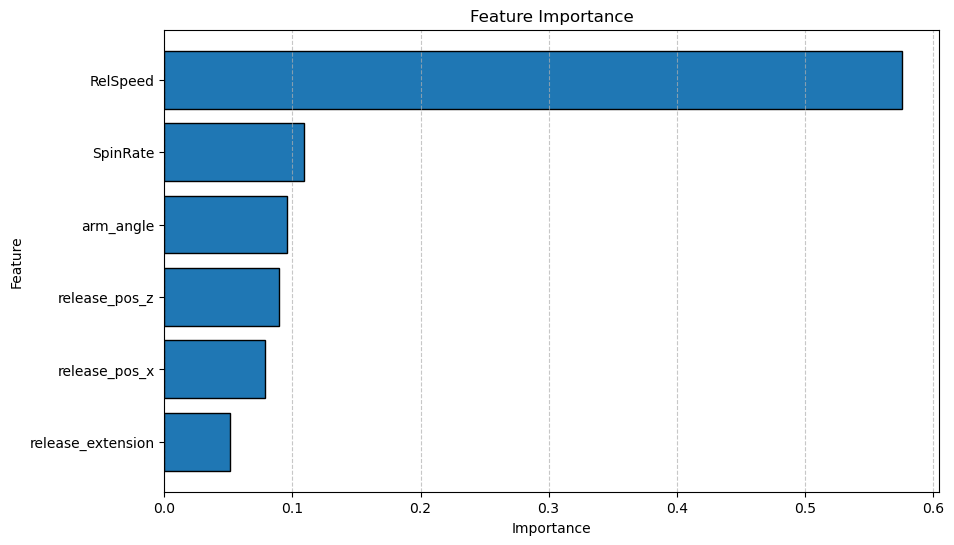

In [88]:
import matplotlib.pyplot as plt
import xgboost as xgb

# Extract feature importances
feature_importances = ivb_model.feature_importances_
feature_names = X.columns

# Create a DataFrame for better visualization
importances_college_data = pd.DataFrame({
    'Feature': feature_names,
    'Importance': feature_importances
}).sort_values(by='Importance', ascending=False)

# Plot feature importances
plt.figure(figsize=(10, 6))
plt.barh(importances_college_data['Feature'], importances_college_data['Importance'], edgecolor='black')
plt.gca().invert_yaxis()  # Invert y-axis to show the highest importance at the top
plt.title('Feature Importance')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.show()


In [89]:
with open('ivb_model.pkl', 'wb') as file:
    pickle.dump(ivb_model, file)

# Load the model
with open('ivb_model.pkl', 'rb') as file:
    ivb_model = pickle.load(file)

In [90]:
college_data['xiVB'] = ivb_model.predict(college_data[features])

college_data = college_data[~(college_data['InducedVertBreak'] >= 30)]
college_data['iVB_oe'] = college_data['InducedVertBreak'] - college_data['xiVB']

In [91]:
college_data[['pitch_type','RelSpeed','release_extension','SpinAxis','HorzBreak','InducedVertBreak', 'xiVB', 'iVB_oe']].head(20)

,pitch_type,RelSpeed,release_extension,SpinAxis,HorzBreak,InducedVertBreak,xiVB,iVB_oe
0,Fastball,88.64954,7.03804,250.778596,18.19655,7.47776,11.722663,-4.244903
1,Fastball,89.17083,6.76113,256.615425,19.23442,5.73662,10.276978,-4.540358
2,Fastball,88.86033,6.82406,258.672111,17.81221,4.64276,11.056500,-6.413740
3,Fastball,88.88316,6.92233,259.487563,18.09017,4.46748,11.081076,-6.613596
4,Fastball,88.48676,6.90635,255.398574,19.82328,6.30012,10.751251,-4.451131
5,Fastball,90.00702,6.77445,253.213497,21.16497,7.47024,6.499631,0.970609
6,ChangeUp,82.37212,7.07870,267.024390,19.99044,2.45559,6.488780,-4.033190
7,ChangeUp,80.66824,7.18853,278.202186,18.21954,-1.20008,6.441677,-7.641757
8,Fastball,92.50922,6.58132,252.351839,19.79178,7.37524,9.803478,-2.428238
9,Fastball,90.17668,7.21782,250.389778,19.20769,7.96382,8.073771,-0.109951


In [92]:
[c for c in college_data.columns]

['PitchNo',
 'Date',
 'Time',
 'PAofInning',
 'PitchofPA',
 'player_name',
 'PitcherId',
 'PitcherThrows',
 'PitcherTeam',
 'Batter',
 'BatterId',
 'BatterSide',
 'BatterTeam',
 'PitcherSet',
 'Inning',
 'Top.Bottom',
 'Outs',
 'Balls',
 'Strikes',
 'TaggedPitchType',
 'AutoPitchType',
 'PitchCall',
 'KorBB',
 'TaggedHitType',
 'PlayResult',
 'OutsOnPlay',
 'RunsScored',
 'Notes',
 'RelSpeed',
 'VertRelAngle',
 'HorzRelAngle',
 'SpinRate',
 'SpinAxis',
 'Tilt',
 'release_pos_z',
 'release_pos_x',
 'release_extension',
 'VertBreak',
 'InducedVertBreak',
 'HorzBreak',
 'PlateLocHeight',
 'PlateLocSide',
 'ZoneSpeed',
 'VertApprAngle',
 'HorzApprAngle',
 'ZoneTime',
 'ExitSpeed',
 'Angle',
 'Direction',
 'HitSpinRate',
 'PositionAt110X',
 'PositionAt110Y',
 'PositionAt110Z',
 'Distance',
 'LastTrackedDistance',
 'Bearing',
 'HangTime',
 'pfxx',
 'pfxz',
 'x0',
 'y0',
 'z0',
 'vx0',
 'vy0',
 'vz0',
 'ax0',
 'ay0',
 'az0',
 'HomeTeam',
 'AwayTeam',
 'Stadium',
 'Level',
 'League',
 'GameID'

## Location Model

In [93]:
college_data.shape

(1098095, 179)

In [94]:
fastballs = ['Fastball', 'Sinker', 'Cutter']
college_fb = college_data[college_data['pitch_type'].isin(fastballs)]

most_common_fb = college_fb.groupby(['PitcherId', 'BatterSide'])['pitch_type'].agg(lambda x: x.mode().iloc[0]).reset_index()
most_common_fb = most_common_fb.rename(columns={'pitch_type': 'most_common_fb'})

college_fb = college_fb.merge(most_common_fb, on=['PitcherId', 'BatterSide'], how='left')

college_fb_filtered = college_fb[college_fb['pitch_type'] == college_fb['most_common_fb']]

average_metrics = college_fb_filtered.groupby(['PitcherId', 'BatterSide', 'most_common_fb']).agg({
    'RelSpeed': 'mean',
    'release_pos_x': 'mean',
    'release_pos_z': 'mean',
    'HorzBreak': 'mean',
    'InducedVertBreak': 'mean'
}).reset_index()

average_metrics = average_metrics.rename(columns={
    'RelSpeed': 'avg_RelSpeed',
    'release_pos_x': 'avg_release_pos_x',
    'release_pos_z': 'avg_release_pos_z',
    'HorzBreak': 'avg_HorzBreak',
    'InducedVertBreak': 'avg_InducedVertBreak'
})

college_data = college_data.merge(average_metrics, on=['PitcherId', 'BatterSide'], how='left')

In [95]:
conditions = [
    (college_data['BatterSide'] == 'Left') & (college_data['PitcherThrows'] == 1),
    (college_data['BatterSide'] == 'Left') & (college_data['PitcherThrows'] == 0),  
    (college_data['BatterSide'] == 'Right') & (college_data['PitcherThrows'] == 1),  
    (college_data['BatterSide'] == 'Right') & (college_data['PitcherThrows'] == 0) 
]

values = [0, 1, 2, 3]

college_data['platoon_state'] = np.select(conditions, values)

count_mapping = {
    (0, 0): 0,
    (0, 1): 1,
    (0, 2): 2,
    (1, 0): 3,
    (1, 1): 4,
    (1, 2): 5,
    (2, 0): 6,
    (2, 1): 7,
    (2, 2): 8,
    (3, 0): 9,
    (3, 1): 10,
    (3, 2): 11
}

college_data['count'] = college_data[['Balls', 'Strikes']].apply(tuple, axis=1).map(count_mapping)

In [96]:
loc_features = ['RelSpeed', 'release_pos_x', 'release_pos_z', 'platoon_state', 
                'count', 'HorzBreak', 'InducedVertBreak', 'release_extension',
                'SpinRate', 'PlateLocHeight', 'PlateLocSide', 'SpinAxis', 'avg_RelSpeed',
                'avg_release_pos_x', 'avg_release_pos_z', 'avg_HorzBreak', 'avg_InducedVertBreak', 
                'arm_angle', 'VertApprAngle', 'iVB_oe']

loc_target = 'delta_run_exp'

In [97]:
college_data = college_data[
    ~(
        ((college_data['pitch_type'] == 'Fastball') & (college_data['RelSpeed'] < 88)) |  # Fastball with RelSpeed < 88
        ((college_data['pitch_type'] == 'Sinker') & (college_data['RelSpeed'] < 85)) |    # Sinker with RelSpeed < 85
        (college_data['RelSpeed'] < 70)                                                   # Any pitch with RelSpeed < 70
    )
]

In [57]:
df = college_data.dropna(subset=loc_features + [loc_target])

X = df[loc_features]
y = df[loc_target]

best_rmse = float('inf')
best_catboost_model = None

def catboost_objective(trial):
    global best_rmse, best_catboost_model

    # Define hyperparameters for optimization
    params = {
        'iterations': trial.suggest_int('iterations', 100, 1500),
        'learning_rate': trial.suggest_float('learning_rate', 1e-3, 1e-1, log=True),
        'depth': trial.suggest_int('depth', 1, 10),
        'min_data_in_leaf': trial.suggest_int('min_data_in_leaf', 1, 100),
        'l2_leaf_reg': trial.suggest_float('l2_leaf_reg', 1e-3, 10.0, log=True),
        'border_count': trial.suggest_int('border_count', 32, 255),
        'bagging_temperature': trial.suggest_float('bagging_temperature', 1e-1, 10.0, log=True),
        'random_strength': trial.suggest_float('random_strength', 1e-3, 10.0, log=True),
    }

    cv = KFold(n_splits=5, shuffle=True, random_state=13)
    cv_scores = []

    for train_idx, val_idx in cv.split(X, y):
        cat_X_train, cat_X_val = X.iloc[train_idx], X.iloc[val_idx]
        cat_y_train, cat_y_val = y.iloc[train_idx], y.iloc[val_idx]

        # Train the CatBoost model
        catboost_model = CatBoostRegressor(**params, random_seed=13, verbose=0)
        catboost_model.fit(cat_X_train, cat_y_train, eval_set=(cat_X_val, cat_y_val), early_stopping_rounds=50, verbose=0)

        cat_y_pred = catboost_model.predict(cat_X_val)

        # Calculate RMSE
        rmse = np.sqrt(mean_squared_error(cat_y_val, cat_y_pred))
        cv_scores.append(rmse)

    mean_rmse = np.mean(cv_scores)

    # Save the best model based on RMSE
    if mean_rmse < best_rmse:
        best_rmse = mean_rmse
        best_catboost_model = catboost_model

    return mean_rmse

# Create and run Optuna study, optimizing to minimize RMSE
catboost_study = optuna.create_study(direction='minimize') 
catboost_study.optimize(catboost_objective, n_trials=50)

# Get the best hyperparameters from the Optuna study
best_catboost_params = catboost_study.best_params
print("Best CatBoost Params:", best_catboost_params)

[I 2025-01-07 21:47:24,563] A new study created in memory with name: no-name-26333b67-cc7d-4dd6-aaf6-82d6514e6a47
[I 2025-01-07 21:48:32,296] Trial 0 finished with value: 0.21004327702271103 and parameters: {'iterations': 179, 'learning_rate': 0.010493429007245415, 'depth': 4, 'min_data_in_leaf': 9, 'l2_leaf_reg': 0.07176551008520639, 'border_count': 181, 'bagging_temperature': 2.1298624934570274, 'random_strength': 2.831236677155834}. Best is trial 0 with value: 0.21004327702271103.
[I 2025-01-07 21:51:16,170] Trial 1 finished with value: 0.20825242918737424 and parameters: {'iterations': 892, 'learning_rate': 0.09126446876056694, 'depth': 3, 'min_data_in_leaf': 46, 'l2_leaf_reg': 0.016162756467069085, 'border_count': 151, 'bagging_temperature': 1.684864524341881, 'random_strength': 2.2338938625445506}. Best is trial 1 with value: 0.20825242918737424.
[I 2025-01-07 21:55:05,247] Trial 2 finished with value: 0.20763446894358228 and parameters: {'iterations': 864, 'learning_rate': 0.071

Best CatBoost Params: {'iterations': 1395, 'learning_rate': 0.0320082628906548, 'depth': 10, 'min_data_in_leaf': 38, 'l2_leaf_reg': 0.002604394536724474, 'border_count': 234, 'bagging_temperature': 2.461189504672554, 'random_strength': 0.35494966982984094}


In [98]:
with open('xrv_model.pkl', 'wb') as file:
    pickle.dump(best_catboost_model, file)

# Load the model
with open('xrv_model.pkl', 'rb') as file:
    xrv_model = pickle.load(file)

In [100]:
import matplotlib.pyplot as plt
import pandas as pd

# Ensure the best_catboost_model is trained
if xrv_model is not None:
    # Get feature importances
    feature_importances = xrv_model.get_feature_importance()
    feature_names = X.columns

    # Create a DataFrame for better visualization
    importances_df = pd.DataFrame({
        'Feature': feature_names,
        'Importance': feature_importances
    }).sort_values(by='Importance', ascending=False)

    # Plot feature importances
    plt.figure(figsize=(10, 6))
    plt.barh(importances_df['Feature'], importances_df['Importance'], edgecolor='black')
    plt.gca().invert_yaxis()  # Invert y-axis to show the highest importance at the top
    plt.title('CatBoost Feature Importance')
    plt.xlabel('Importance')
    plt.ylabel('Feature')
    plt.grid(axis='x', linestyle='--', alpha=0.7)
    plt.show()
else:
    print("No trained CatBoost model found!")


ValueError: All arrays must be of the same length